In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.datasets import load_files
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Problem Statement

Estimate
1.  type of restrants,dishes,cuisines,cost for dinning preffered
2.  Location famous for online orders and book_table(what rest_type)
3.  Restrants famous for paricular dishes(dish_liked)
4.  Places with common menus and unique dishes.
5.  Use the voting,rate to estimate the best restrant in bangalores
6. Sentimental analysis (review list)

In [3]:
zomato = pd.read_csv("zomato.csv")
zomato.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [5]:
# Percentage of Nul Values
pd.DataFrame(round(zomato.isnull().sum()/zomato.shape[0] * 100,3), columns = ["Nan"])  

,Nan
url,0.000
address,0.000
name,0.000
online_order,0.000
book_table,0.000
rate,15.034
votes,0.000
phone,2.336
location,0.041
rest_type,0.439


### Dropping the columns 

- Ideas to fill the null values
- Lets drop dish_liked as it contains more than 50% null values
- Drop the phone number as we cannot manipulate them
- approx_cost-- We can try to cluster it according to its neighbors price or using the mean values
- Rate - We try to fill after analysing the reveiws_list

In [6]:
zomato=zomato.drop(['url','dish_liked','phone'],axis=1)

### Altering the column Names as required

In [8]:
zomato.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'approx_cost(for two people)',
       'reviews_list', 'menu_item', 'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [9]:
zomato= zomato.rename(columns={"approx_cost(for two people)" : "Cost_of_two",
                                "reviews_list": "reviews",
                                 "menu_item"  : "menu",
                                 "listed_in(type)": "type",
                                 "listed_in(city)": "city"})

### Changes with respect to the rate and the cost

In [10]:
zomato['rest_type'].value_counts()[:10]

Quick Bites           19132
Casual Dining         10330
Cafe                   3732
Delivery               2604
Dessert Parlor         2263
Takeaway, Delivery     2037
Casual Dining, Bar     1154
Bakery                 1141
Beverage Shop           867
Bar                     697
Name: rest_type, dtype: int64

In [11]:
zomato.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost_of_two,reviews,menu,type,city
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [12]:
zomato['rate']=zomato['rate'].str.split('/').str[0]

### Filling the NEW shops and null values with the rating based on the reviews

In [13]:
sd= zomato.copy(deep=True)
sd= zomato[zomato['rate']=='NEW']
fd= zomato[zomato['rate'].isna()]
sfd= pd.concat([sd,fd])
sfd= sfd[sfd['reviews']!=" "] ## Making sure that the review is not empty

In [14]:
import nltk
nltk.download("stopwords")

stopwords= nltk.corpus.stopwords.words('english')
stopwords.remove('not')
stemmer= nltk.stem.PorterStemmer()
import re

def clean_data(doc):
    doc= doc.lower()
    doc= re.sub(r"\W"," ",doc)
    doc= re.sub(r"\d"," ",doc)
    doc= re.sub(r"\s+"," ",doc)
    doc=re.sub("[^a-z\s]","",doc)
    words= doc.split(" ")
    doc= re.sub(r" [@#$%\&\*\(\)\<\>\?\'\":;\]\[-] ", " ",doc)
    word_imp= [ stemmer.stem(word) for word in words if word not in stopwords]
    doc_cleaned=" ".join(word_imp)
    return doc_cleaned

sfd["reviews"]=sfd["reviews"].apply(clean_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mooventh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [17]:
sfd['scores'] = sfd['reviews'].apply(lambda reviews: sid.polarity_scores(reviews))

sfd['compound']  = sfd['scores'].apply(lambda score_dict: score_dict['compound'])

sfd['neu']  = sfd['scores'].apply(lambda score_dict: score_dict['neu'])

sfd['comp_score'] = sfd['compound'].apply(lambda c: 'pos' if c >=0.2 else 'neg')

sfd.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost_of_two,reviews,menu,type,city,scores,compound,neu,comp_score
72,"Opposite ICICi Bank, Hanuman Nagar, Banashanka...",Spicy Tandoor,No,No,NEW,0,Banashankari,Quick Bites,North Indian,150,rate rate n cost chicken roll high fine tast ...,[],Delivery,Banashankari,"{'neg': 0.0, 'neu': 0.574, 'pos': 0.426, 'comp...",0.9694,0.574,pos
75,"39, S B M Colony, Near-Sita Circle, 1st Stage,...",Om Sri Vinayaka Chats,No,No,NEW,0,Banashankari,"Takeaway, Delivery","Street Food, Fast Food",500,,[],Delivery,Banashankari,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,0.000,neg
110,"594, 24 The Cross BSK, Opposte Oriental Bank, ...",Hari Super Sandwich,No,No,NEW,0,Banashankari,"Takeaway, Delivery","Sandwich, Pizza, Beverages",200,rate rate n mani time locat bda crispi n crun...,[],Delivery,Banashankari,"{'neg': 0.046, 'neu': 0.866, 'pos': 0.088, 'co...",0.4939,0.866,pos
130,"28, 4th Cross Road, Dwaraka Nagar, Banashankar...",Roll Magic Fast Food,No,No,NEW,0,Banashankari,"Takeaway, Delivery","Biryani, Rolls, Chinese",200,,[],Delivery,Banashankari,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,0.000,neg
131,"3/16, 22 Main Road, Magenta Block, PES College...",Foodlieious Multi Cuisine,No,No,NEW,0,Banashankari,Quick Bites,North Indian,100,,[],Delivery,Banashankari,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,0.000,neg


In [18]:
sfd["comp_score"].value_counts()

neg    7228
pos    2755
Name: comp_score, dtype: int64

- Assumption NEW starts lets be good as they are trying new
- Compound_Score with score greater than 0.2 will be given positive with a rating as 4 
- Lesser than 0.2 is given negative with a rating as 3

In [19]:
def comp(comp_score):
    if comp_score =='pos':
        return 4
    else:
        return 3
sfd['new_rate']=sfd['comp_score'].apply(comp)

In [20]:
nsd= sfd.drop(['scores','compound','neu','rate','comp_score'],1)
nsd=nsd.rename(columns={"new_rate":"rate"})
nzomato= zomato.loc[(zomato['rate']!='NEW')]
nzomato =nzomato.loc[zomato['rate'].notna()]
frame=[nzomato,nsd]
final=pd.concat(frame)

In [21]:
final.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost_of_two,reviews,menu,type,city
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


### Fixing Cost_of_Two

In [22]:
final= final[final['rate']!='-']
final['Cost_of_two']=final['Cost_of_two'].replace(",","",regex=True).astype(float)

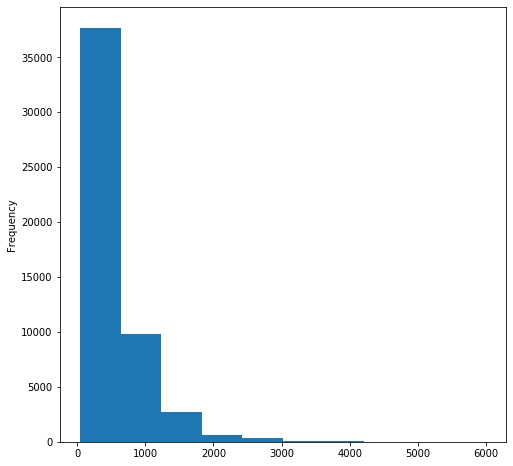

In [23]:
final['Cost_of_two'].plot(kind='hist',figsize=(8,8))

In [24]:
### Adjustments on the data types
final['rate']=final['rate'].astype("float")
# round(final['Cost_of_two'].mean()) ---- > 586
final['Cost_of_two']=final['Cost_of_two'].fillna('586')
final['rest_type']= final['rest_type'].fillna('Quick Bites')  # Filled with mode(maximum occurance)

### Cuisines

In [25]:
menu= final[final['cuisines'].isna()]
# There are around 10 restrants without the cuisines type we can fill after analysing the menu enterily

In [26]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

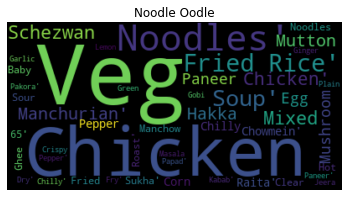

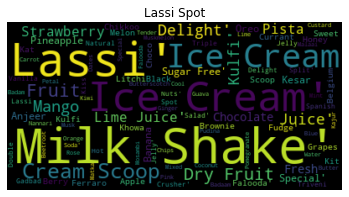

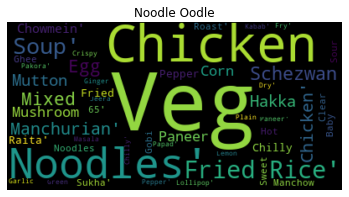

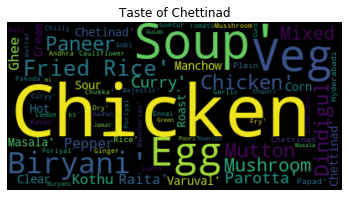

In [27]:
WC= menu[menu['menu'].map(lambda d: len(d)) > 5]
# Start with one menu:
# Create and generate a word cloud image:
for i in range(0,4):
    text= WC.menu.iloc[i]
    wordcloud = WordCloud().generate(text)

# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(WC['name'].iloc[i])
    plt.show()

In [28]:
final.loc[(pd.isnull(final.cuisines)), 'cuisines'] = "Briyani"
final.loc[(final.name=="Lassi Spot"),"cuisines"]= "Desserts, Ice Cream "

In [29]:
zomato.shape

(51717, 14)

In [31]:
final

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost_of_two,reviews,menu,type,city
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51644,"7/3, ASK Tower, Kundanahalli Gate, Next to Bat...",Punjabi Thadka,No,No,3.0,0,Brookefield,Quick Bites,North Indian,400,,[],Dine-out,Whitefield
51675,"2E2, 4th Cross Road, Devasandra Industrial Est...",Topsy Turvey,No,No,4.0,0,Whitefield,Bar,Finger Food,900,rate rate n divin joint flavour vegetarian no...,[],Drinks & nightlife,Whitefield
51710,"2E2, 4th Cross Road, Devasandra Industrial Est...",Topsy Turvey,No,No,4.0,0,Whitefield,Bar,Finger Food,900,rate rate n divin joint flavour vegetarian no...,[],Pubs and bars,Whitefield
51713,"Number 10, Garudachar Palya, Mahadevapura, Whi...",Vinod Bar And Restaurant,No,No,3.0,0,Whitefield,Bar,Finger Food,600,,[],Pubs and bars,Whitefield


In [32]:
#final.drop('only_rate',1,inplace=True)

In [33]:
final.isnull().sum()

address          0
name             0
online_order     0
book_table       0
rate             0
votes            0
location        21
rest_type        0
cuisines         0
Cost_of_two      0
reviews          0
menu             0
type             0
city             0
dtype: int64

### Data is clean for futher processing

### Univariate Analysis 

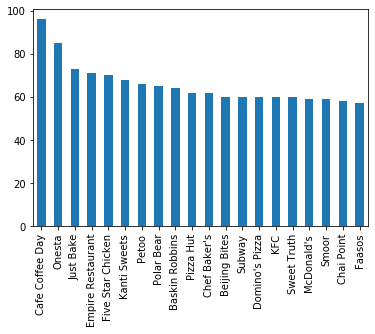

In [34]:
# Top 20 shops in the zomato list
final['name'].value_counts()[:20].plot(kind='bar')

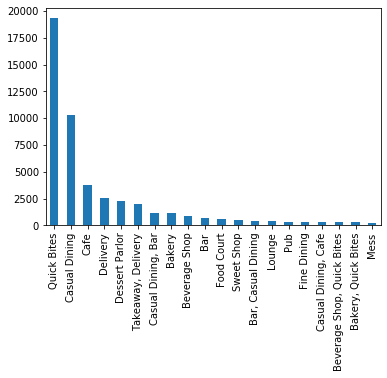

In [35]:
# Bangalore a IT hub everone needs a quick bites (reallly sad)
final['rest_type'].value_counts()[:20].plot(kind='bar')

In [37]:
final['Cost_of_two']=final['Cost_of_two'].astype(int)

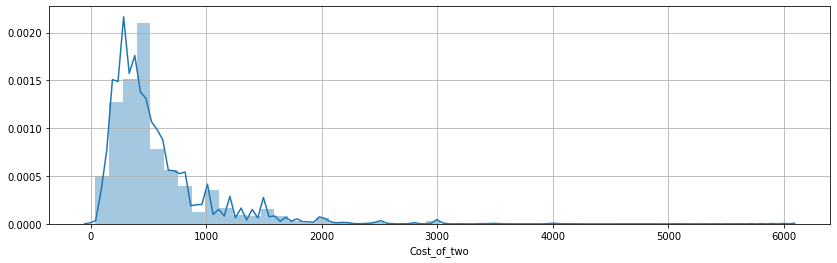

In [38]:
plt.figure(figsize=(14,4))
plt.grid()
sns.distplot(final['Cost_of_two'])
#final['Cost_of_two'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

Most of them are spending on zomato food within the price range of 200-1000

### Briyani Shops


In [39]:
print(final[final['name'].str.lower().str.contains("briyani")].shape)
Briyani= final[final['name'].str.lower().str.contains("briyani")]
Briyani.shape

(59, 14)


(59, 14)

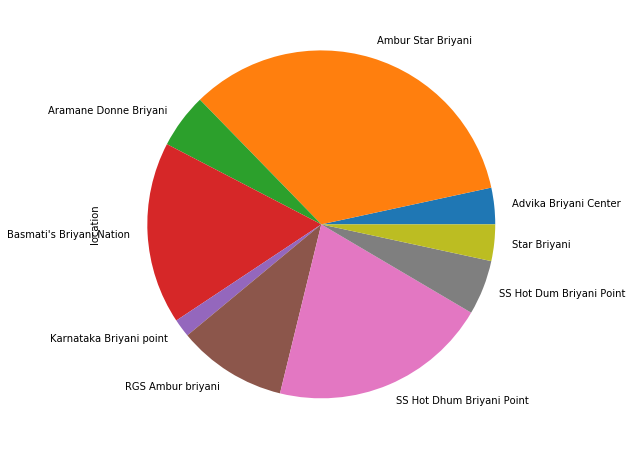

In [40]:
Briyani.groupby('name')['location'].count().plot(figsize=(8,8),kind='pie')

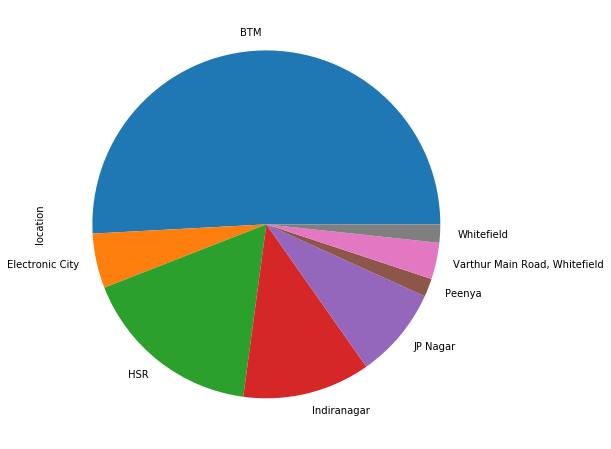

In [41]:
Briyani.groupby('location')['location'].count().plot(figsize=(8,8),kind='pie')

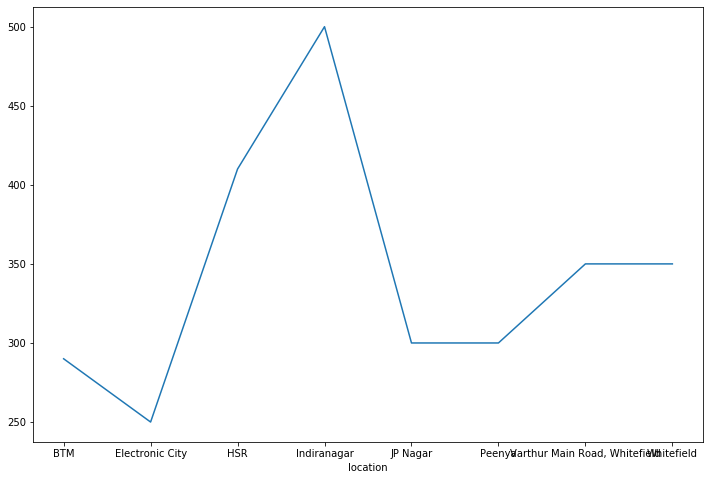

In [42]:
Briyani.groupby('location')['Cost_of_two'].mean().plot(figsize=(12,8),kind='line')
# Briyani is costly in IndiraNagar and lesser in JP Nagar,Peenya

In [43]:
Briyani.groupby('online_order')['location'].count()

online_order
No     30
Yes    29
Name: location, dtype: int64

Inference:

- There is around 35 briyani centers and top 5 unique briyani shops spreaded across
- Ambur star briyani is one with the more count compared to other briyani centers
- While karnatka briyani point is unique to a particular location

- BTM has a highest briyani foods(Briyani lovers it the place to chill)
- Price range of briyani varies from 200-500
- Most of them with online orders

### All the missing datas are imputed and ready for Prediction of rate

In [44]:
# Getting dummies is not going to work here as we have columns with address,name,menu
# Using factorize with reference to one of the kaggle kernels

def Encode(zomato):
    for column in zomato.columns[~zomato.columns.isin(['rate', 'Cost_of_two', 'votes'])]:
        zomato[column] = zomato[column].factorize()[0]
    return zomato

zomato_en = Encode(final.copy())

In [45]:
zomato_en

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost_of_two,reviews,menu,type,city
0,0,0,0,0,4.1,775,0,0,0,800,0,0,0,0
1,1,1,0,1,4.1,787,0,0,1,800,1,0,0,0
2,2,2,0,1,3.8,918,0,1,2,800,2,0,0,0
3,3,3,1,1,3.7,88,0,2,3,300,3,0,0,0
4,4,4,1,1,3.8,166,1,0,4,600,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51644,9027,6765,1,1,3.0,0,55,2,5,400,21273,0,4,29
51675,11468,8761,1,1,4.0,0,25,17,238,900,22577,0,5,29
51710,11468,8761,1,1,4.0,0,25,17,238,900,22577,0,6,29
51713,11471,8764,1,1,3.0,0,25,17,238,600,21273,0,6,29


In [46]:
zomato_en['Cost_of_two']=zomato_en['Cost_of_two'].astype(int)

In [47]:
X= zomato_en.drop('Cost_of_two',axis=1)
y= zomato_en['Cost_of_two']

### Using backward (wrapper method) to select the feature

In [48]:
import scipy.stats as st
import statsmodels.api         as     sm

In [49]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues
#model.summary()

const           9.799583e-303
address         1.943260e-169
name             7.793920e-02
online_order    3.779684e-188
book_table       0.000000e+00
rate            3.019381e-152
votes           4.750576e-126
location         2.338820e-68
rest_type       3.976923e-279
cuisines        6.083636e-192
reviews          4.658410e-13
menu             1.760621e-04
type             2.026824e-99
city             1.533762e-05
dtype: float64

In [50]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['address', 'online_order', 'book_table', 'rate', 'votes', 'location', 'rest_type', 'cuisines', 'reviews', 'menu', 'type', 'city']


In [51]:
X= X[selected_features_BE]

In [52]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,accuracy_score
from sklearn.model_selection import train_test_split

In [55]:
import xgboost

C:\Users\Mooventh\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [56]:
RFR=RandomForestRegressor()
RFR.fit(X_train,y_train)

GB= GradientBoostingRegressor()
GB.fit(X_train,y_train)

Ada= AdaBoostRegressor()
Ada.fit(X_train,y_train)

XG= xgboost.XGBRegressor()
XG.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [57]:
RFR_train_pred=RFR.predict(X_train)
GB_train_predict=GB.predict(X_train)
Ada_train_predict=Ada.predict(X_train)
XG_train_predict=XG.predict(X_train)

In [58]:
RFR_test_pred=RFR.predict(X_test)
GB_test_predict=GB.predict(X_test)
Ada_test_predict=Ada.predict(X_test)
XG_test_predict=XG.predict(X_test)

<Figure size 720x360 with 0 Axes>

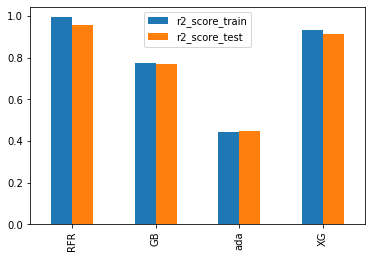

In [59]:
## r2_score

r2_score_train=[r2_score(y_train,RFR_train_pred),r2_score(y_train,GB_train_predict),r2_score(y_train,Ada_train_predict),r2_score(y_train,XG_train_predict)]
r2_score_test =[r2_score(y_test,RFR_test_pred),r2_score(y_test,GB_test_predict),r2_score(y_test,Ada_test_predict),r2_score(y_test,XG_test_predict)]
a=pd.DataFrame({'r2_score_train':r2_score_train,'r2_score_test':r2_score_test})
plt.figure(figsize=[10,5]) 
a.plot(kind='bar')
plt.xticks(np.arange(4),['RFR','GB','ada','XG'])
plt.show()

## Overall RandomForest and XGboost are performing best in the prediction

### Beginners Code open for suggestions.. Thanks